# Milestone project 2: ***SkimLit***

The purpose of this project is to build an NLP model to make reading medical abstracts easier.


In [32]:
!nvidia-smi

Wed Nov 12 12:02:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             34W /   70W |    8309MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [33]:
## Get data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 23.52 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [34]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [35]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [36]:
# start our experiments using 20k datasets
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [37]:
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [38]:
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

In [39]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [40]:
train_lines[0],train_lines[1],train_lines[110]

('###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'RESULTS\tNon-transfer patients had less @-day death/myocardial infarction -LSB- @ % vs. @ % ( tertiary ) ; adjusted odds ratio ( OR ) : @ ( @-@ @ ) , P = @ -RSB- ; transferred ( @ % ) and tertiary patients were similar -LSB- adjusted OR : @ ( @-@ @ ) , P = @ -RSB- .\n')

In [41]:
len(train_lines[0])

12

In [42]:
def preprocess_text_with_line_numbers(filename):
    """
    return a list of dictionaries of abstract line data.
    """
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()
            for abstract_line_number,abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1]
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)
        else:
            abstract_lines += line
    return abstract_samples
             
            
            
    
        
    

In [43]:
train_data = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_data = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_data = preprocess_text_with_line_numbers(data_dir + "test.txt")
train_data[:15]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontari

In [44]:
# turn data into DataFrame for more visualize
import pandas as pd
train_data_df = pd.DataFrame(train_data)
val_data_df = pd.DataFrame(val_data)
test_data_df = pd.DataFrame(test_data)
train_data_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [45]:
test_data_df.head(10)

,target,text,line_number,total_lines
0,BACKGROUND,This study analyzed liver function abnormaliti...,0,8
1,RESULTS,A post hoc analysis was conducted with the use...,1,8
2,RESULTS,Liver function tests ( LFTs ) were measured at...,2,8
3,RESULTS,Survival analyses were used to assess the asso...,3,8
4,RESULTS,The percentage of patients with abnormal LFTs ...,4,8
5,RESULTS,When mean hemodynamic profiles were compared i...,5,8
6,RESULTS,Multivariable analyses revealed that patients ...,6,8
7,CONCLUSIONS,Abnormal LFTs are common in the ADHF populatio...,7,8
8,CONCLUSIONS,Elevated MELD-XI scores are associated with po...,8,8
9,BACKGROUND,Minimally invasive endovascular aneurysm repai...,0,12


In [46]:
val_data_df.head(10)

,target,text,line_number,total_lines
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,0,9
1,BACKGROUND,It is not clear whether these patients would b...,1,9
2,OBJECTIVE,We sought to determine whether a @-month cours...,2,9
3,METHODS,Asthmatic patients who were IgE sensitized to ...,3,9
4,METHODS,Primary outcomes were improvement in quality o...,4,9
5,RESULTS,Sixty-five patients were randomized .,5,9
6,RESULTS,Fifty-nine patients started treatment ( @ rece...,6,9
7,RESULTS,Fifty-six patients took the full @ months of m...,7,9
8,RESULTS,"Between the voriconazole and placebo groups , ...",8,9
9,CONCLUSIONS,We were unable to show a beneficial effect of ...,9,9


In [47]:
train_data_df

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
...,...,...,...,...
180035,RESULTS,For the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"For PAV , a significantly greater percentage o...",8,11
180037,RESULTS,Both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"Compared with standard statin monotherapy , th...",10,11


In [48]:
train_data_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [49]:
import matplotlib.pyplot as plt

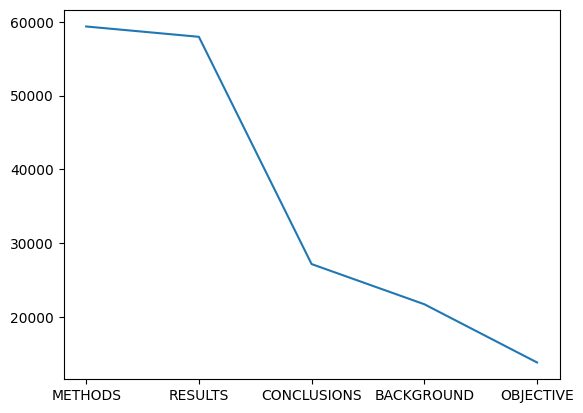

In [50]:
plt.plot(train_data_df.target.value_counts())

<BarContainer object of 5 artists>

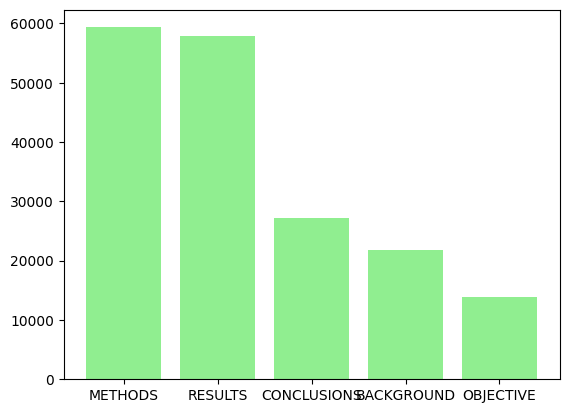

In [51]:
target_values = train_data_df.target.value_counts()
plt.bar(target_values.index,target_values.values,color="lightgreen")

<Axes: ylabel='Frequency'>

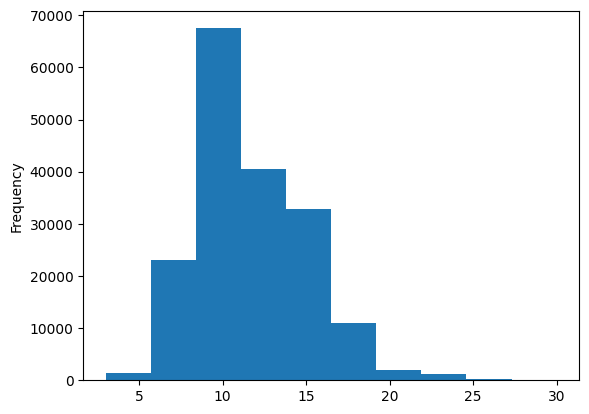

In [52]:
train_data_df.total_lines.plot.hist()

(array([ 1393., 23102., 67507., 40551., 32807., 11026.,  2051.,  1223.,
          291.,    89.]),
 array([ 3. ,  5.7,  8.4, 11.1, 13.8, 16.5, 19.2, 21.9, 24.6, 27.3, 30. ]),
 <BarContainer object of 10 artists>)

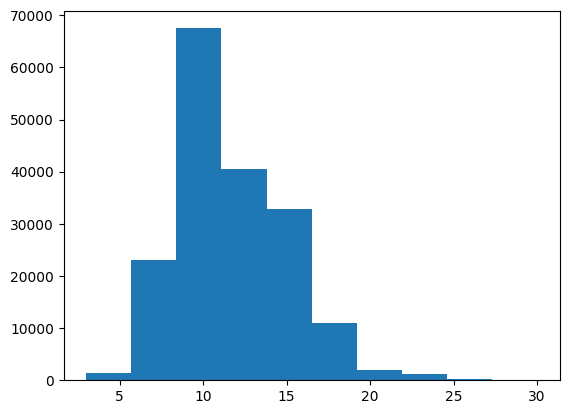

In [53]:
plt.hist(train_data_df.total_lines)

In [54]:
max(train_data_df.total_lines),min(train_data_df.total_lines),len(train_data_df.total_lines)

(30, 3, 180040)

In [55]:
train_sentences = train_data_df["text"].tolist()
val_sentences = val_data_df["text"].tolist()
test_sentences = test_data_df["text"].tolist()
train_sentences[:2]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .']

In [56]:
val_sentences[:4]

['IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'It is not clear whether these patients would benefit from antifungal treatment .',
 'We sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .',
 'Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .']

In [57]:
test_sentences[:5]

['This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .',
 'Liver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'Survival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "The percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up ."]

## Make numeric labels

In [58]:
train_data_df["target"].to_numpy()

array(['OBJECTIVE', 'METHODS', 'METHODS', ..., 'RESULTS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

In [59]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

one_hot_encoder = OneHotEncoder(sparse_output=False)  # use sparse=False for dense NumPy array

train_labels_one_hot = one_hot_encoder.fit_transform(train_data_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot   = one_hot_encoder.transform(val_data_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot  = one_hot_encoder.transform(test_data_df["target"].to_numpy().reshape(-1, 1))


In [60]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encoder labels

In [61]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_data_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_data_df["target"].to_numpy())

In [62]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [63]:
test_labels_encoded[:5]

array([0, 4, 4, 4, 4])

In [64]:
# Get class names and number of classes from label encoder instances
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [65]:
class_names[1]

'CONCLUSIONS'

## Model 1: baseline, naive bayes model

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [67]:
model_0 = Pipeline([
    ("tf_idf",TfidfVectorizer()),
    ("clf",MultinomialNB()),
    
])

model_0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [68]:
model_0.score(val_sentences,val_labels_encoded)

0.7218323844829869

In [69]:
baseline_preds = model_0.predict(val_sentences)

In [70]:
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [71]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-11-12 12:02:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-11-12 12:02:21 (12.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [72]:
from helper_functions import calculate_results

In [73]:
baseline_results = calculate_results(y_true=val_labels_encoded,y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [74]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

## Model 1: 1D Conv layer
how to vectorize and then embedd words?
tokenize using keras tokenization class,
embedded tokenized words in higher order embeding using keras embedding class
build the model, compile the model and fit the model and finally play around with model hyperparameters, parameter tuning, evaluating,tweaking,...

In [75]:
# total number of sentences
total_sentences = len(train_sentences)

In [76]:
# total number of tokens
total_token = [len(i.split()) for i in train_sentences]


In [77]:
# sequence_length = tf.round(total_token/total_sentences)
# sequence_length

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

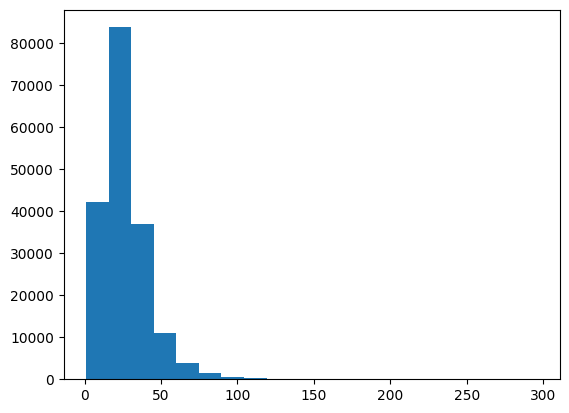

In [78]:
# the distribution of looks like
import matplotlib.pyplot as plt
plt.hist(total_token,bins=20)

In [79]:
import numpy as np
output_seq_len = int(np.percentile(total_token,95))
output_seq_len

55

In [80]:
from tensorflow.keras import layers
max_tokens = 68000
output_sequence_len = 55
text_vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                          standardize="lower_and_strip_punctuation",
                                           split="whitespace",
                                          encoding="utf-8",
                                          output_mode="int",
                                          name="Tokenization_layer",
                                          output_sequence_length=output_seq_len)


In [81]:
text_vectorizer.adapt(train_sentences+val_sentences+test_sentences)

In [82]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:{len(target_sentence.split())}")
print(f"\nVectorized text:{text_vectorizer(target_sentence)}")

Text:
Patients in the control group took Celecoxib Capsule ( @ g each time , twice per day ) .

Length of text:19

Vectorized text:[  12    5    2   35   13 1480 5720 1911  239  122   60  565  160  108
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [83]:
text_vectorizer.get_config()

{'name': 'Tokenization_layer',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 68000}

In [84]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab)


68000

In [85]:
# Embedding layer
token_embeded = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                            output_dim=128,
                             mask_zero=True
                            )


In [86]:
print(f"Sentence before vectorization:\n{target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"\nsentence after vectorized\n: {vectorized_sentence}")
print(f"shape of vectorized sentence: {vectorized_sentence.shape}")
embeded_sentence = token_embeded(vectorized_sentence)
print(type(vectorized_sentence))
print(f"\nvectorized sentence after embeded:{embeded_sentence}")

Sentence before vectorization:
Patients in the control group took Celecoxib Capsule ( @ g each time , twice per day ) .

sentence after vectorized
: [[  12    5    2   35   13 1480 5720 1911  239  122   60  565  160  108
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
shape of vectorized sentence: (1, 55)
<class 'tensorflow.python.framework.ops.EagerTensor'>

vectorized sentence after embeded:[[[ 0.04651177  0.02090453  0.03333839 ...  0.01722484 -0.03355868
   -0.04490712]
  [ 0.03414513 -0.01963178  0.01732612 ... -0.03623716 -0.02559095
    0.04124799]
  [ 0.02977461  0.01230497 -0.00669533 ...  0.04763814 -0.0456048
    0.03670522]
  ...
  [ 0.00924976  0.02305089  0.01725489 ... -0.04147559  0.03260473
   -0.01633295]
  [ 0.00924976  0.02305089  0.01725489 ... -0.04147559  0.03260473
   -0.01633295]
  [ 0.00924976  0.0

In [87]:
embeded_sentence.shape

TensorShape([1, 55, 128])

## Creating datasets

In [88]:
len(train_sentences),len(train_labels_one_hot[0])
train_labels_one_hot[0][10:],train_labels_one_hot.shape
print(train_labels_one_hot[0])


[0. 0. 0. 1. 0.]


In [89]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))


In [90]:
train_labels_one_hot.shape

(180040, 5)

In [91]:
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


## Mode 1: Conv1D with token embeddings

In [92]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs) # map text inputs into integer, vectorize the inputs
token_embeddings = token_embeded(text_vectors) # create embedding
x = layers.SpatialDropout1D(0.3)(token_embeddings)
x = layers.Conv1D(filters=64,kernel_size=5,padding="same",activation="relu",kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.GlobalAveragePooling1D()(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5,activation="softmax",name="output_layer")(x)
model_1 = tf.keras.Model(inputs,outputs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [93]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Tokenization_layer              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 55, 128)        │     8,704,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 55, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,745,349 (33.36 MB)

 Trainable params: 8,745,349 (33.36 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [95]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [96]:
history_model_1 = model_1.fit(train_dataset,
           epochs=5,
           steps_per_epoch=int(0.1 * len(train_dataset)),
           validation_data=val_dataset,
           validation_steps=int(0.1 * len(val_dataset)),
           )

Epoch 1/5


I0000 00:00:1762948947.789294     150 cuda_dnn.cc:529] Loaded cuDNN version 90300


562/562 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4708 - loss: 1.2804 - val_accuracy: 0.7181 - val_loss: 0.7661
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7050 - loss: 0.8066 - val_accuracy: 0.7537 - val_loss: 0.6959
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7322 - loss: 0.7333 - val_accuracy: 0.7676 - val_loss: 0.6666
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7469 - loss: 0.7058 - val_accuracy: 0.7596 - val_loss: 0.6427
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7548 - loss: 0.7011 - val_accuracy: 0.7643 - val_loss: 0.6318


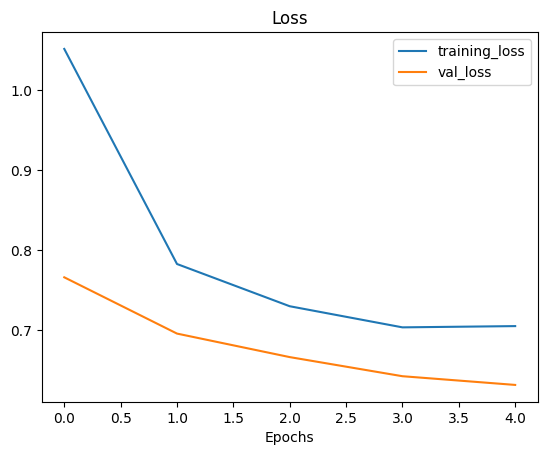

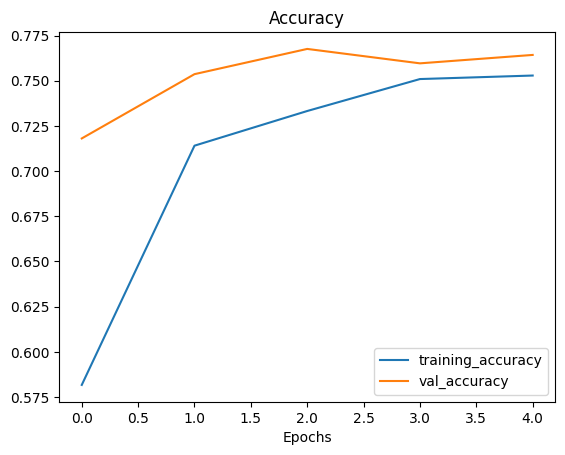

In [97]:
from helper_functions import plot_loss_curves
plot_loss_curves(history_model_1)

In [98]:
model_1.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7707 - loss: 0.6272


[0.6273674964904785, 0.7734013199806213]

In [99]:
model_1_pred_probs = model_1.predict(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [100]:
model_1_pred_probs.shape,model_1_pred_probs

((30212, 5),
 array([[3.5898358e-01, 2.5925010e-01, 1.2421788e-01, 1.7841777e-01,
         7.9130627e-02],
        [3.9363763e-01, 4.2859063e-01, 1.8377241e-02, 1.3065711e-01,
         2.8737424e-02],
        [4.5623976e-01, 2.2798238e-02, 3.8476107e-03, 5.1700467e-01,
         1.0976702e-04],
        ...,
        [2.4844059e-05, 2.9401849e-03, 1.1542630e-02, 2.0831800e-05,
         9.8547149e-01],
        [1.0696881e-01, 2.4309202e-01, 2.2175847e-01, 6.4638011e-02,
         3.6354265e-01],
        [2.6287910e-01, 5.1589853e-01, 8.3284676e-02, 5.5462901e-02,
         8.2474753e-02]], dtype=float32))

In [101]:
# convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [102]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [103]:
val_labels_encoded.shape,val_labels_one_hot.shape

((30212,), (30212, 5))

In [104]:
model_1_results = calculate_results(y_true=val_labels_encoded,y_pred=model_1_preds)

In [105]:
model_1_results

{'accuracy': 77.34012974976831,
 'precision': 0.7721486680192667,
 'recall': 0.773401297497683,
 'f1': 0.7633819978394385}

In [106]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: feature extfraction with pretrained token embeddings

In [107]:
from huggingface_hub import snapshot_download
import tensorflow_hub as hub
USE_path = snapshot_download(repo_id="Dimitre/universal-sentence-encoder")
USE =  hub.KerasLayer(handle=model_path)
embeddings = USE([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])
    
print(embeddings)

# The following are example embedding output of 512 dimensions per sentence
# Embedding for: The quick brown fox jumps over the lazy dog.
# [-0.03133016 -0.06338634 -0.01607501, ...]
# Embedding for: I am a sentence for which I would like to get its embedding.
# [0.05080863 -0.0165243   0.01573782, ...]


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

tf.Tensor(
[[-0.03133018 -0.06338634 -0.016075   ... -0.0324278  -0.04575739
   0.05370454]
 [ 0.0508086  -0.01652432  0.01573777 ...  0.00976658  0.0317012
   0.01788118]], shape=(2, 512), dtype=float32)


In [108]:
USE(["hello world"]).shape

TensorShape([1, 512])

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       trainable=False,
                                       name="Univeral sentence encoder")

